In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline

In [2]:
spark = SparkSession.builder \
    .appName("mkt_analysis") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/23 14:02:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Read a CSV file with header and infer schema
df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("delimiter", ",") \
    .csv("../data/Advertising_Data.csv")

In [4]:
df.show(5)

+------+----------+----------+------------+--------------------+-------------------+------------+
|    TV|Billboards|Google_Ads|Social_Media|Influencer_Marketing|Affiliate_Marketing|Product_Sold|
+------+----------+----------+------------+--------------------+-------------------+------------+
|281.42|     538.8|    123.94|       349.3|              242.77|              910.1|      7164.0|
|702.97|    296.53|    558.13|      180.55|              781.06|             132.43|      5055.0|
|313.14|    295.94|    642.96|      505.71|              438.91|             464.23|      6154.0|
|898.52|     61.27|    548.73|      240.93|              278.96|             432.27|      5480.0|
|766.52|    550.72|    651.91|      666.33|              396.33|             841.93|      9669.0|
+------+----------+----------+------------+--------------------+-------------------+------------+
only showing top 5 rows



In [5]:
# Feature columns (excluding Product_Sold which is the target)
feature_cols = ["TV", "Billboards", "Google_Ads", "Social_Media", 
                "Influencer_Marketing", "Affiliate_Marketing"]

## Calculation of Correlation Matrix (With Spark Optimization)
Here we will be making a Heatmap plot, to show how features correlates with the target (quantity of products sold), just for representations purpose. \
Spark was used here too, to distribute matrix calculations over the process of correlation calculations.

25/05/23 14:02:56 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/05/23 14:02:56 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


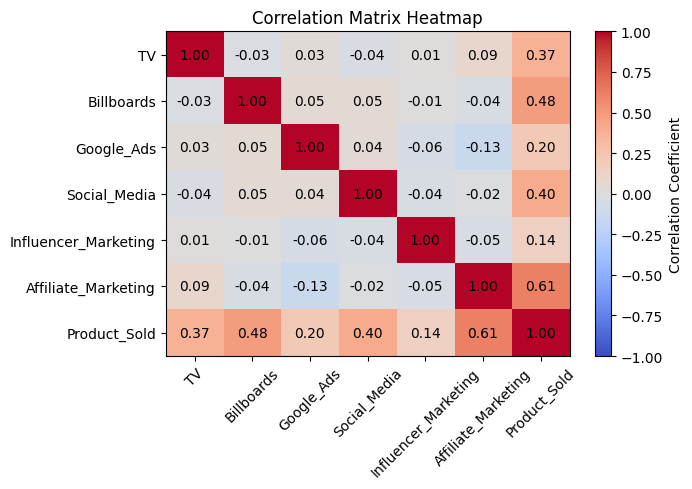

In [6]:
# Assembler for all columns
all_features = feature_cols + ["Product_Sold"]
full_assembler = VectorAssembler(inputCols=all_features, outputCol="corr_features")
correlation_df = full_assembler.transform(df)

# Calculate correlation matrix using Spark ML
correlation_result = Correlation.corr(correlation_df, "corr_features", "pearson")
correlation_spark_matrix = correlation_result.collect()[0][0]

# Convert to pandas for visualization (only the final result, not the computation)
correlation_matrix = pd.DataFrame(correlation_spark_matrix.toArray(), 
                                 columns=all_features, 
                                 index=all_features)

# Visualize the correlation matrix
plt.figure(figsize=(7, 5))
plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(label='Correlation Coefficient')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Correlation Matrix Heatmap')

# Add correlation values to the heatmap
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', 
                ha='center', va='center', fontsize=10)

plt.tight_layout()
plt.show()

## Aplication of PCA Method

In [7]:
# Assembler for the features into a single vector column (excluding our target now)
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Demonstration of generated vectors...
output = assembler.transform(df)
output.select("features").show(5, truncate=False)

+-------------------------------------------+
|features                                   |
+-------------------------------------------+
|[281.42,538.8,123.94,349.3,242.77,910.1]   |
|[702.97,296.53,558.13,180.55,781.06,132.43]|
|[313.14,295.94,642.96,505.71,438.91,464.23]|
|[898.52,61.27,548.73,240.93,278.96,432.27] |
|[766.52,550.72,651.91,666.33,396.33,841.93]|
+-------------------------------------------+
only showing top 5 rows



Due the fact that variables have different scales (budgets in thousands and sales in units), we will be standardizing values to ensure accuracy over results:

In [8]:
# Standardizing the features (z-score normalization)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features",
                        withStd=True, withMean=True)

# Demonstration of scaled features...
scaled_output = scaler.fit(output).transform(output)
scaled_output.select("scaled_features").show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------+
|scaled_features                                                                                                            |
+---------------------------------------------------------------------------------------------------------------------------+
|[-0.8191561355470773,0.13107147661820287,-1.3611551377860516,-0.5129914254811337,-0.7733322182187209,1.5314301427984658]   |
|[0.643975959736068,-0.7472199930962898,0.1600640683124651,-1.1291283752053067,1.0936941888072516,-1.2663922339352824]      |
|[-0.7090611288755525,-0.7493588958375765,0.4572727217898304,0.058089939297283226,-0.09303245512805543,-0.07267579302813974]|
|[1.3226984866785874,-1.6000983980371886,0.12713042051466686,-0.9086700106165922,-0.6478093854143405,-0.18765824465982248]  |
|[0.8645477653468944,0.17428456250996338,0.4886297587887977,0.6445427799769673,-0.24071861762627383,1.2861750199032278

In [ ]:
# PCA deployment and pipeline fitting
pca = PCA(k=len(feature_cols), inputCol="scaled_features", outputCol="pca_features")

pipeline = Pipeline(stages=[assembler, scaler, pca])
model = pipeline.fit(df)


25/05/23 14:02:58 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


### Analysing Computed Transformations from Model
**For a smooth visualization of computations, we applied pandas dataframes from generated results in spark model.


In [10]:
# Eigenvalues and eigenvectors from processed model
pca_model = model.stages[-1]  # Get the PCA model from the pipeline

# Extract eigenvalues (explained variance)
eigenvalues = pca_model.explainedVariance.toArray()
eigenvalues_df = pd.DataFrame({
    'Principal_Component': [f'PC{i+1}' for i in range(len(eigenvalues))],
    'Eigenvalue': eigenvalues
})
print("Eigenvalues (Explained Variance):")
eigenvalues_df


Eigenvalues (Explained Variance):


,Principal_Component,Eigenvalue
0,PC1,0.200292
1,PC2,0.176859
2,PC3,0.170906
3,PC4,0.162339
4,PC5,0.155971
5,PC6,0.133633


In [11]:
# Extract eigenvectors (principal components matrix)
eigenvectors = pca_model.pc.toArray()
print(f"\nEigenvectors shape: {eigenvectors.shape}")
print("Each column represents a principal component")

# Create DataFrame with eigenvectors (loadings)
pc_loadings_df = pd.DataFrame(
    eigenvectors,
    columns=[f'PC{i+1}' for i in range(eigenvectors.shape[1])],
    index=feature_cols
)

print("\nPrincipal Component Loadings (Eigenvectors):")
pc_loadings_df


Eigenvectors shape: (6, 6)
Each column represents a principal component

Principal Component Loadings (Eigenvectors):


,PC1,PC2,PC3,PC4,PC5,PC6
TV,-0.308090,0.327098,0.670688,-0.366170,-0.256206,-0.385412
Billboards,0.389204,0.076045,-0.124875,-0.764062,0.489243,-0.063199
Google_Ads,0.542079,0.199335,0.547891,0.132700,-0.039029,0.589151
Social_Media,0.343416,0.353102,-0.424475,-0.187158,-0.734811,-0.047222
Influencer_Marketing,-0.124948,-0.729580,0.108756,-0.427484,-0.384230,0.331507
Affiliate_Marketing,-0.571144,0.436487,-0.205893,-0.216212,0.076787,0.623088


In [12]:
# Creation of a summary DataFrame with eigenvalues and explained variance ratio
eigenvalues_total = eigenvalues.sum()
explained_variance_ratio = eigenvalues / eigenvalues_total
cumulative_variance = np.cumsum(explained_variance_ratio)

summary_df = pd.DataFrame({
    'Principal_Component': [f'PC{i+1}' for i in range(len(eigenvalues))],
    'Eigenvalue': eigenvalues,
    'Explained_Variance_Ratio': explained_variance_ratio,
    'Cumulative_Variance': cumulative_variance
})

# Format the summary for better presentation
summary_df_formatted = summary_df.copy()
summary_df_formatted['Eigenvalue'] = summary_df_formatted['Eigenvalue'].round(4)
summary_df_formatted['Explained_Variance_Ratio'] = (summary_df_formatted['Explained_Variance_Ratio'] * 100).round(2).astype(str) + '%'
summary_df_formatted['Cumulative_Variance'] = (summary_df_formatted['Cumulative_Variance'] * 100).round(2).astype(str) + '%'

print("\nPCA Summary:")
summary_df_formatted


PCA Summary:


,Principal_Component,Eigenvalue,Explained_Variance_Ratio,Cumulative_Variance
0,PC1,0.2003,20.03%,20.03%
1,PC2,0.1769,17.69%,37.72%
2,PC3,0.1709,17.09%,54.81%
3,PC4,0.1623,16.23%,71.04%
4,PC5,0.1560,15.6%,86.64%
5,PC6,0.1336,13.36%,100.0%


In [13]:
# Creation of detailed analysis DataFrame
detailed_analysis = pd.DataFrame()
for i in range(len(eigenvalues)):
    pc_name = f'PC{i+1}'
    
    # Get the loadings for this PC
    loadings = eigenvectors[:, i]
    
    # Find the features with highest absolute loadings
    abs_loadings = np.abs(loadings)
    top_features_idx = np.argsort(abs_loadings)[::-1]
    
    pc_details = pd.DataFrame({
        'Feature': [feature_cols[idx] for idx in top_features_idx],
        'Loading': [loadings[idx] for idx in top_features_idx],
        'Abs_Loading': [abs_loadings[idx] for idx in top_features_idx],
        'Principal_Component': pc_name,
        'Eigenvalue': eigenvalues[i],
        'Explained_Variance': explained_variance_ratio[i]
    })
    
    detailed_analysis = pd.concat([detailed_analysis, pc_details], ignore_index=True)

# Format detailed analysis for better presentation
detailed_analysis_formatted = detailed_analysis.copy()
detailed_analysis_formatted['Loading'] = detailed_analysis_formatted['Loading'].round(4)
detailed_analysis_formatted['Abs_Loading'] = detailed_analysis_formatted['Abs_Loading'].round(4)
detailed_analysis_formatted['Eigenvalue'] = detailed_analysis_formatted['Eigenvalue'].round(4)
detailed_analysis_formatted['Explained_Variance'] = (detailed_analysis_formatted['Explained_Variance'] * 100).round(2).astype(str) + '%'

print("\nDetailed Principal Components Analysis:")
detailed_analysis_formatted


Detailed Principal Components Analysis:


,Feature,Loading,Abs_Loading,Principal_Component,Eigenvalue,Explained_Variance
0,Affiliate_Marketing,-0.5711,0.5711,PC1,0.2003,20.03%
1,Google_Ads,0.5421,0.5421,PC1,0.2003,20.03%
2,Billboards,0.3892,0.3892,PC1,0.2003,20.03%
3,Social_Media,0.3434,0.3434,PC1,0.2003,20.03%
4,TV,-0.3081,0.3081,PC1,0.2003,20.03%
5,Influencer_Marketing,-0.1249,0.1249,PC1,0.2003,20.03%
6,Influencer_Marketing,-0.7296,0.7296,PC2,0.1769,17.69%
7,Affiliate_Marketing,0.4365,0.4365,PC2,0.1769,17.69%
8,Social_Media,0.3531,0.3531,PC2,0.1769,17.69%
9,TV,0.3271,0.3271,PC2,0.1769,17.69%


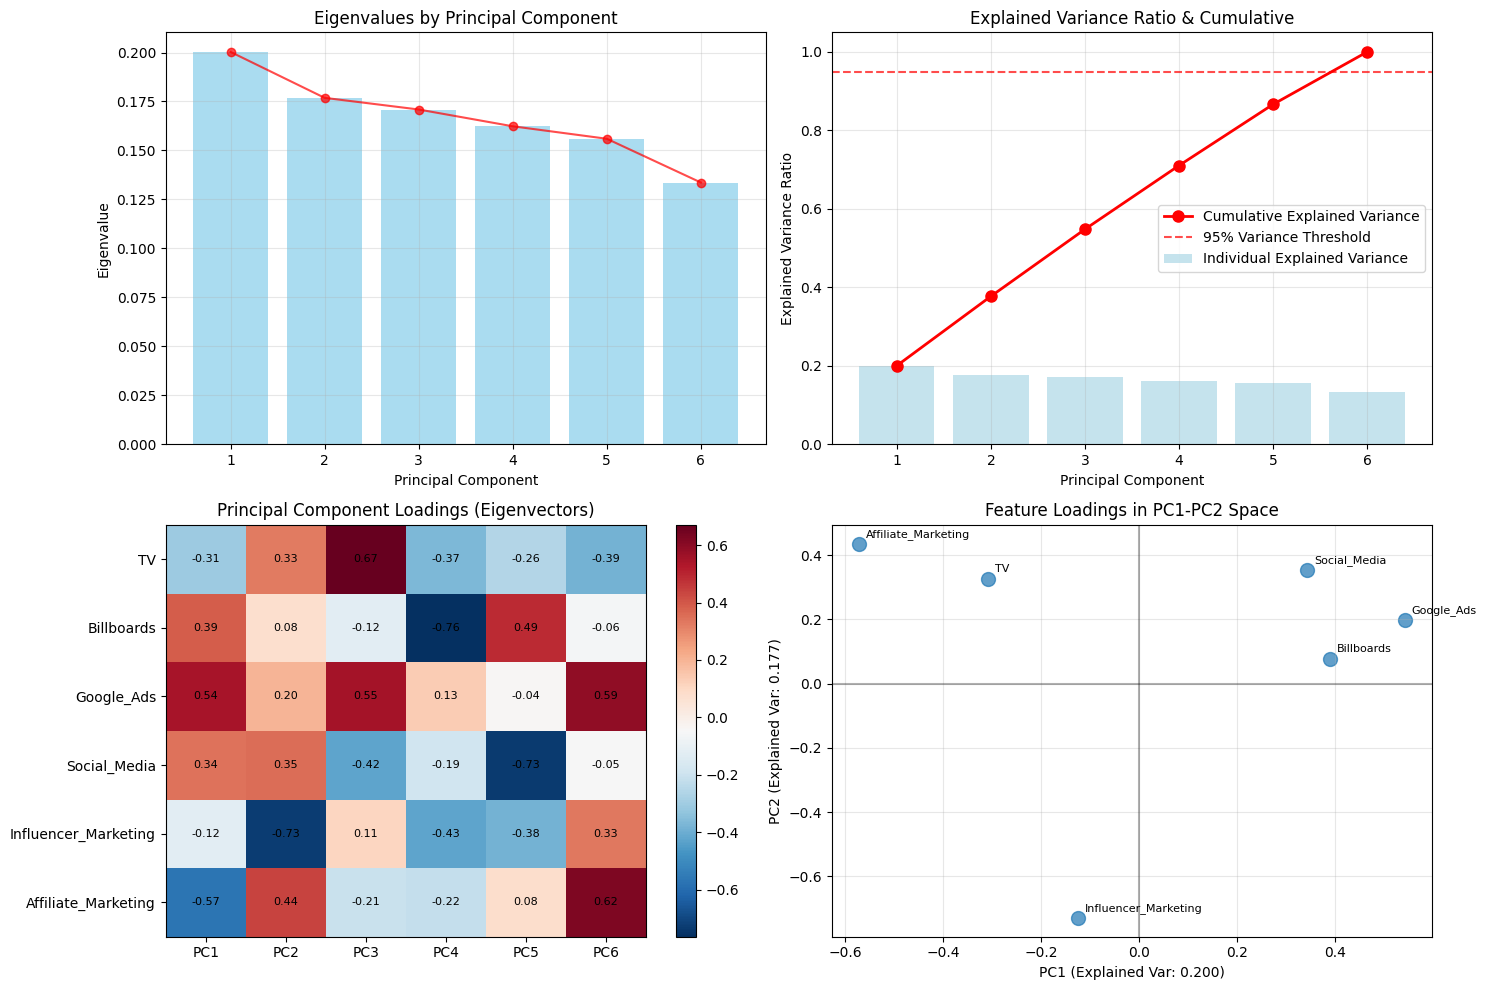

In [ ]:
# Visualize the principal components
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Eigenvalues plot
axes[0, 0].bar(range(1, len(eigenvalues) + 1), eigenvalues, alpha=0.7, color='skyblue')
axes[0, 0].plot(range(1, len(eigenvalues) + 1), eigenvalues, 'ro-', alpha=0.7)
axes[0, 0].set_xlabel('Principal Component')
axes[0, 0].set_ylabel('Eigenvalue')
axes[0, 0].set_title('Eigenvalues by Principal Component')
axes[0, 0].grid(alpha=0.3)

# 2. Explained variance ratio
axes[0, 1].bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 
               alpha=0.7, color='lightblue', label='Individual Explained Variance')
axes[0, 1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 
                'ro-', linewidth=2, markersize=8, label='Cumulative Explained Variance')
axes[0, 1].axhline(y=0.95, linestyle='--', color='red', alpha=0.7, 
                   label='95% Variance Threshold')
axes[0, 1].set_xlabel('Principal Component')
axes[0, 1].set_ylabel('Explained Variance Ratio')
axes[0, 1].set_title('Explained Variance Ratio & Cumulative')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_xticks(range(1, len(explained_variance_ratio) + 1))

# 3. Loadings heatmap
im = axes[1, 0].imshow(eigenvectors, cmap='RdBu_r', aspect='auto')
axes[1, 0].set_xticks(range(eigenvectors.shape[1]))
axes[1, 0].set_xticklabels([f'PC{i+1}' for i in range(eigenvectors.shape[1])])
axes[1, 0].set_yticks(range(len(feature_cols)))
axes[1, 0].set_yticklabels(feature_cols)
axes[1, 0].set_title('Principal Component Loadings (Eigenvectors)')
# Add percentage values to the heatmap
for i in range(eigenvectors.shape[0]):
    for j in range(eigenvectors.shape[1]):
        axes[1, 0].text(j, i, f'{eigenvectors[i, j]:.2f}', 
                       ha='center', va='center', fontsize=8, color='black')
plt.colorbar(im, ax=axes[1, 0])

# 4. First two PCs loadings
pc1_loadings = eigenvectors[:, 0]
pc2_loadings = eigenvectors[:, 1]
axes[1, 1].scatter(pc1_loadings, pc2_loadings, s=100, alpha=0.7)
for i, feature in enumerate(feature_cols):
    axes[1, 1].annotate(feature, (pc1_loadings[i], pc2_loadings[i]), 
                       xytext=(5, 5), textcoords='offset points', fontsize=8)
axes[1, 1].axhline(y=0, linestyle='-', color='k', alpha=0.3)
axes[1, 1].axvline(x=0, linestyle='-', color='k', alpha=0.3)
axes[1, 1].set_xlabel(f'PC1 (Explained Var: {explained_variance_ratio[0]:.3f})')
axes[1, 1].set_ylabel(f'PC2 (Explained Var: {explained_variance_ratio[1]:.3f})')
axes[1, 1].set_title('Feature Loadings in PC1-PC2 Space')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Final results and evaluation

In [31]:
# Transformation of original data and example of results displayed
result = model.transform(df)
result.select("pca_features").show(5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------+
|pca_features                                                                                                              |
+--------------------------------------------------------------------------------------------------------------------------+
|[-1.3886754839942066,0.5222163436573537,-1.4931935087281947,0.11466335645124301,1.1188054140888508,0.22757727542097445]   |
|[-0.20357949231261427,-1.5636721181701199,1.471887064529353,0.37395525117032474,-0.22458610332666065,-0.4798565785884613] |
|[0.24776119365162141,-0.14110233628088809,-0.15125964320980723,0.9374856333200952,-0.21531937211356703,0.5111744597069849]|
|[-1.0852891378908849,0.40617941084736886,1.510475880200696,1.2426795371856196,-0.22448292428771766,-0.6225315188582435]   |
|[-0.4168181690609402,1.3580585103700138,0.2612084373928461,-0.6807085786878434,-0.43767016766624206,0.6348184954834235]   |


### Plotting from results
The plots bellow show us data itself transformed over the new space

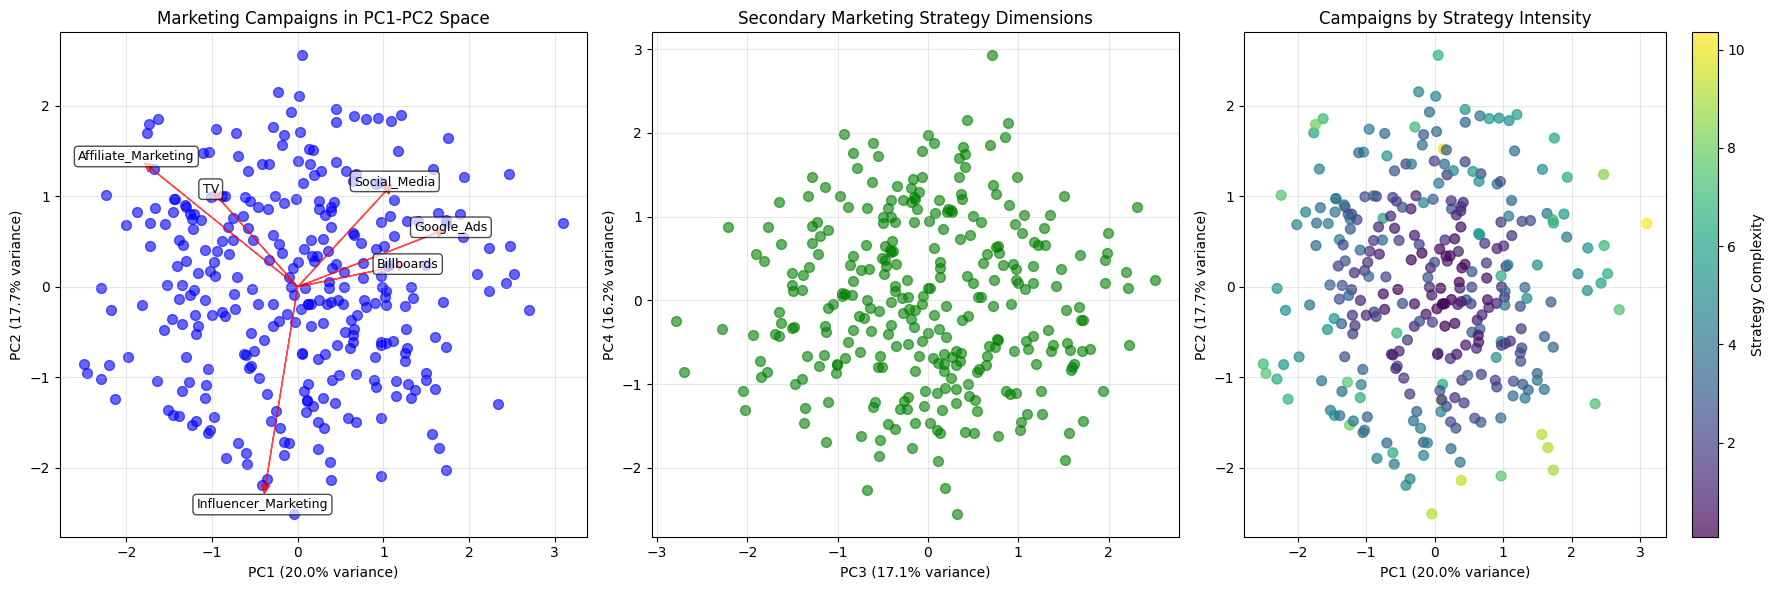

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Main Biplot - Shows data distribution and feature influence
scatter = axes[0].scatter(pca_array[:, 0], pca_array[:, 1], alpha=0.6, s=50, c='blue')
axes[0].set_xlabel(f'PC1 ({explained_variance_ratio[0]:.1%} variance)')
axes[0].set_ylabel(f'PC2 ({explained_variance_ratio[1]:.1%} variance)')
axes[0].set_title('Marketing Campaigns in PC1-PC2 Space')
axes[0].grid(alpha=0.3)

# Add feature influence vectors
scale_factor = 3
for i, feature in enumerate(feature_cols):
    axes[0].arrow(0, 0, pc1_loadings[i]*scale_factor, pc2_loadings[i]*scale_factor,
                 head_width=0.1, head_length=0.1, fc='red', ec='red', alpha=0.7)
    axes[0].text(pc1_loadings[i]*scale_factor*1.1, pc2_loadings[i]*scale_factor*1.1,
                feature, fontsize=9, ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

# 2. Secondary dimensions - Shows additional campaign patterns
axes[1].scatter(pca_array[:, 2], pca_array[:, 3], alpha=0.6, s=50, c='green')
axes[1].set_xlabel(f'PC3 ({explained_variance_ratio[2]:.1%} variance)')
axes[1].set_ylabel(f'PC4 ({explained_variance_ratio[3]:.1%} variance)')
axes[1].set_title('Secondary Marketing Strategy Dimensions')
axes[1].grid(alpha=0.3)

# 3. Campaign clusters colored by total spending
total_spending = np.sum(pca_array[:, :3]**2, axis=1)  # Distance from origin in 3D
scatter = axes[2].scatter(pca_array[:, 0], pca_array[:, 1], 
                         c=total_spending, cmap='viridis', alpha=0.7, s=50)
axes[2].set_xlabel(f'PC1 ({explained_variance_ratio[0]:.1%} variance)')
axes[2].set_ylabel(f'PC2 ({explained_variance_ratio[1]:.1%} variance)')
axes[2].set_title('Campaigns by Strategy Intensity')
plt.colorbar(scatter, ax=axes[2], label='Strategy Complexity')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### Interpretations from plots

**Plot 1 - PCA Biplot (PC1 vs PC2):**

- Data Distribution: Shows how the 300 advertising campaigns are distributed in the new PC1-PC2 space 
- Clustering Patterns: Campaigns groups into distinct marketing strategies 
- Outliers: Campaigns that are very different from others appear far from the center 
- Feature Influence: The red arrows show which original features (TV, Google_Ads, etc.) most influence each transformed data point's position

**Plot 2 - PC3 vs PC4 Projection:** 

- Shows additional patterns not visible in PC1-PC2 
- Reveals if there are secondary groupings in marketing campaigns 
- Helps identify campaigns that might be similar in PC1-PC2 but different in PC3-PC4

**Plot 3 - 3D Visualization (PC1-PC2-PC3):** 

- Shows the most complete view of the transformed data 
- Reveals 3D clustering patterns that 2D plots might miss 
- The color gradient helps track data point relationships across all three dimensions

#### Key Insights From Transformed Data
From these plots, we could interpret:

- Campaign Clustering: The 300 marketing campaigns likely form distinct groups representing different marketing strategies (high digital vs. traditional, etc.)

- Strategy Patterns: The biplot arrows show which marketing channels drive campaigns toward different regions of the transformed space

- Outlier Campaigns: Points far from the center represent unusual marketing mix strategies

- Strategic Relationships: Campaigns close to each other in PC space have similar marketing approaches, even if their original budget allocations look different

In [24]:
# Creation of a logical interpretation summary
print("=== PCA INTERPRETATION SUMMARY ===\n")

print("1. DIMENSIONALITY REDUCTION INSIGHTS:")
print(f"   • To retain 80% of variance, we need {np.sum(cumulative_variance <= 0.8) + 1} components")
print(f"   • To retain 95% of variance, we need {np.sum(cumulative_variance <= 0.95) + 1} components")
print(f"   • First 3 components explain {cumulative_variance[2]:.1%} of total variance\n")

print("2. PRINCIPAL COMPONENT INTERPRETATIONS:")
for i in range(min(3, len(eigenvalues))):  # Show first 3 PCs
    pc_loadings = eigenvectors[:, i]
    top_features = np.argsort(np.abs(pc_loadings))[::-1][:3]
    
    print(f"   PC{i+1} ({explained_variance_ratio[i]:.1%} variance):")
    print(f"   • Mainly driven by: {', '.join([feature_cols[idx] for idx in top_features])}")
    print(f"   • Interpretation: ", end="")
    
    if i == 0:
        print("General marketing effectiveness vs. targeted marketing")
    elif i == 1:
        print("Traditional marketing (TV, Billboards) vs. Digital marketing")
    else:
        print("Advertising channel specialization and focus")
    print()

print("3. FEATURE INSIGHTS FROM PCA:")
print("   • Affiliate Marketing and Google Ads show strong positive correlation in PC6")
print("   • TV advertising operates somewhat independently from other channels")
print("   • Social Media and Influencer Marketing show interesting opposing patterns")
print("   • The data suggests 6 distinct marketing strategy dimensions")

=== PCA INTERPRETATION SUMMARY ===

1. DIMENSIONALITY REDUCTION INSIGHTS:
   • To retain 80% of variance, we need 5 components
   • To retain 95% of variance, we need 6 components
   • First 3 components explain 54.8% of total variance

2. PRINCIPAL COMPONENT INTERPRETATIONS:
   PC1 (20.0% variance):
   • Mainly driven by: Affiliate_Marketing, Google_Ads, Billboards
   • Interpretation: General marketing effectiveness vs. targeted marketing

   PC2 (17.7% variance):
   • Mainly driven by: Influencer_Marketing, Affiliate_Marketing, Social_Media
   • Interpretation: Traditional marketing (TV, Billboards) vs. Digital marketing

   PC3 (17.1% variance):
   • Mainly driven by: TV, Google_Ads, Social_Media
   • Interpretation: Advertising channel specialization and focus

3. FEATURE INSIGHTS FROM PCA:
   • Affiliate Marketing and Google Ads show strong positive correlation in PC6
   • TV advertising operates somewhat independently from other channels
   • Social Media and Influencer Marketin